# M2177.003100 Deep Learning <br> Assignment #4 Implementing Variational AutoEncoder - part1 MNIST data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Chaehun Shin, September

In this notebook, you will learn how to implement Variational AutoEncoder(VAEs). <br>
The goal here is to build VAEs that draw a digit(MNIST data). <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Team_#)

### Some helpful tutorials and references for assignment #1:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013).
- [4] Doersch, Carl. "Tutorial on variational autoencoders." arXiv preprint arXiv:1606.05908 (2016).
- [5] Kingma, Diederik P., and Max Welling. "An Introduction to Variational Autoencoders." arXiv preprint arXiv:1906.02691 (2019).

## 0. Download and load MNIST datasets
The MNIST dataset will be downloaded into the 'data' directory. If you want to change the directory where the data is saved, change mnist_data_dir with where you want. <br>

In [9]:
from download import *
import os
from utils import load_mnist
mnist_data_dir = './data'
prepare_data_dir(mnist_data_dir)
download_mnist(mnist_data_dir)
data_array , data_y = load_mnist(os.path.join(mnist_data_dir,'mnist'))
print(data_array.shape)
print(data_y.shape)

Found MNIST - skip
(70000, 28, 28, 1)
(70000, 10)


## <a name="1"></a> 1. Build a network

In this section, you will implement neural networks for (1)encoder $q_\phi(z \mid x)$ to encode latent variable distribution from the image of digits (2)decoder $p_\theta(x \mid z)$ to reconstruct the image of digits from the sample of latent variable distribution. You can use some function in *ops.py* or you can make it as you want. Just write the code in whatever way you find most clear.

In [10]:
from ops import conv2d
from ops import lrelu
from ops import de_conv
from ops import fully_connect
from ops import conv_cond_concat
from ops import batch_normal

import tensorflow as tf
import numpy as np

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

It is time for an encoder. It takes img_data, img_dim(should be 28\*28\*1=784 here), latent_dim(dimension of the z). It should return the latent variable distribution with the dimension of latent_dim. <br>
Because we model the latent variable distribution as multivariate Gaussian, we can make the distribution with only mean and covariance matrix. Also as we model each latent variable as independent, covariance matrix becomes a diagonal matrix and we need only (latent_dim) number elements. so we make outputs as 2 (latent_dim) dimension vectors from encoder function with neural network. I recommend to use logvar not variance itself because of scalability.

<img src='./pictures/encoder.png'>

Maybe you can use two neural networks for mean and logvar vectors. However it is recommended to use only one neural network with two last branches.<br> 
For example, if you use 5 layer networks, first 4 layers are shared and there are 2 5th layer each corresponding to mean and logvar.

In [69]:
def encoder(img_data, img_dim=784, latent_dim=10, reuse=False):
    with tf.variable_scope('enc', reuse=reuse):
        ### ToDo ###
        flatten = tf.contrib.layers.flatten(img_data)
        h1 = tf.layers.dense(flatten, units=512, activation='relu')
        h2 = tf.layers.dense(h1, units=latent_dim*2)
        mean = h2[:, :latent_dim]
        logvar = h2[:, latent_dim:]
        
        return mean, logvar

Now, it's time for a decoder model. It takes sample of the latent variable distribution(z), latent_dim(dimension of the latent variable), and img_dim(28\*28\*1 here). It should return the reconstruction of the original image as x_hat. <br>
Decoder models the likelihood distributions and in here, we model each pixel as Bernoulli distribution(So we use binary cross entropy as loss function). So **you should use the sigmoid function to make the output as probability in [0, 1]**

<img src='./pictures/decoder.png'>

Note that you should define Tensorflow Variables within the variable scope again.

In [91]:
def decoder(z, latent_dim=10, img_dim=784, reuse=False):
    with tf.variable_scope('dec', reuse=reuse):
        ### ToDo ###
        h1 = tf.layers.dense(z, units=512, activation='relu')
        decoder_output = tf.layers.dense(h1, units=img_dim, activation='sigmoid')
        
        return decoder_output

## <a name="2"></a> 2. Build a main part and train it

In this section, you will implement the main part. You should define the loss function and reparameterization trick (TODO part). Then run the code and check the model reconstructs a digit.

When you are done, run the following to check your implementations.

Following code will make 'samples_for_test/vae_mnist' directory that resulting image will be saved in. You can change the directory as you want.

Also, you can change all other hyperparameters such as learning rate, batch size. But be sure to define **batch size bigger than 16**.(Because, we visualize 16 images per batch in training time.)

In [58]:
from utils import load_mnist
from utils import save_images
from utils import show_images
from utils import vis_square
from utils import sample_label
from utils import getNext_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 
import os

learning_rate = 1e-4
batch_size = 128
EPOCH = 1000
loss_step    = 500
display_step = 2500
latent_channel=16
img_channel = 1
output_size = 28
sample_dir = 'samples_for_test/vae_mnist'

if os.path.exists(sample_dir) == False:
    os.makedirs(sample_dir)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Because sampling can't be differentiated, it needs some tricks called as reparameterization trick.<br>
First, epsilon is sampled from unit Gaussian distribution with latent_dim. Then, scale and shift it by using mean and logvar.<br>
Because sampling is out of graph, gradient can be flowed through all paths and encoder/decoder are trained end-to-end.

<img src='./pictures/reparameterization.png'>
Left image is original version and right image is representation by using reparameterization trick.

Results are visualized in order of original image, reconstructed image, generated image from the left.

In [104]:
tf.reset_default_graph()

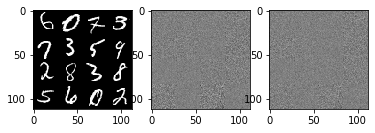

<Epoch:1/1000, Step:500/545>total_loss: 186.3658, kl_loss: 20.9665, recon_loss: 165.3993
<Epoch:2/1000, Step:455/545>total_loss: 156.6451, kl_loss: 20.1392, recon_loss: 136.5059
<Epoch:3/1000, Step:410/545>total_loss: 143.8391, kl_loss: 20.9740, recon_loss: 122.8650
<Epoch:4/1000, Step:365/545>total_loss: 135.5986, kl_loss: 22.3593, recon_loss: 113.2393
<Epoch:5/1000, Step:320/545>total_loss: 134.8965, kl_loss: 21.5154, recon_loss: 113.3812


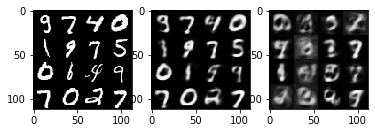

<Epoch:6/1000, Step:275/545>total_loss: 127.9354, kl_loss: 22.3823, recon_loss: 105.5532
<Epoch:7/1000, Step:230/545>total_loss: 126.3959, kl_loss: 22.1866, recon_loss: 104.2093
<Epoch:8/1000, Step:185/545>total_loss: 124.8255, kl_loss: 21.6889, recon_loss: 103.1366
<Epoch:9/1000, Step:140/545>total_loss: 125.4527, kl_loss: 21.9156, recon_loss: 103.5371
<Epoch:10/1000, Step:095/545>total_loss: 124.6458, kl_loss: 22.3906, recon_loss: 102.2552


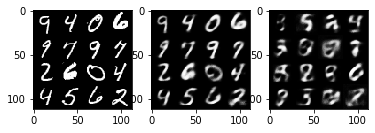

<Epoch:11/1000, Step:050/545>total_loss: 115.6267, kl_loss: 22.8175, recon_loss: 92.8092
<Epoch:12/1000, Step:005/545>total_loss: 117.4135, kl_loss: 22.2655, recon_loss: 95.1480
<Epoch:12/1000, Step:505/545>total_loss: 119.5610, kl_loss: 22.2446, recon_loss: 97.3164
<Epoch:13/1000, Step:460/545>total_loss: 115.1333, kl_loss: 22.1287, recon_loss: 93.0045
<Epoch:14/1000, Step:415/545>total_loss: 115.7851, kl_loss: 22.4301, recon_loss: 93.3550


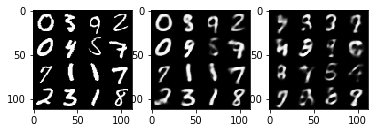

<Epoch:15/1000, Step:370/545>total_loss: 114.4385, kl_loss: 22.6437, recon_loss: 91.7947
<Epoch:16/1000, Step:325/545>total_loss: 118.2145, kl_loss: 23.0404, recon_loss: 95.1741
<Epoch:17/1000, Step:280/545>total_loss: 114.9932, kl_loss: 22.4218, recon_loss: 92.5714
<Epoch:18/1000, Step:235/545>total_loss: 114.6213, kl_loss: 23.4464, recon_loss: 91.1749
<Epoch:19/1000, Step:190/545>total_loss: 108.3981, kl_loss: 22.4950, recon_loss: 85.9031


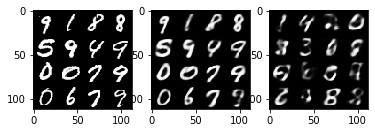

<Epoch:20/1000, Step:145/545>total_loss: 111.2579, kl_loss: 22.9388, recon_loss: 88.3192
<Epoch:21/1000, Step:100/545>total_loss: 111.3484, kl_loss: 23.0759, recon_loss: 88.2724
<Epoch:22/1000, Step:055/545>total_loss: 113.2870, kl_loss: 23.0343, recon_loss: 90.2527
<Epoch:23/1000, Step:010/545>total_loss: 111.6941, kl_loss: 23.5272, recon_loss: 88.1669
<Epoch:23/1000, Step:510/545>total_loss: 107.5819, kl_loss: 22.9281, recon_loss: 84.6538


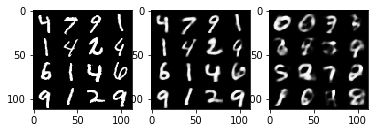

<Epoch:24/1000, Step:465/545>total_loss: 111.1203, kl_loss: 22.8797, recon_loss: 88.2406
<Epoch:25/1000, Step:420/545>total_loss: 111.7585, kl_loss: 23.3149, recon_loss: 88.4436
<Epoch:26/1000, Step:375/545>total_loss: 107.0376, kl_loss: 23.1947, recon_loss: 83.8428
<Epoch:27/1000, Step:330/545>total_loss: 110.5078, kl_loss: 23.2789, recon_loss: 87.2289
<Epoch:28/1000, Step:285/545>total_loss: 112.8906, kl_loss: 23.4550, recon_loss: 89.4356


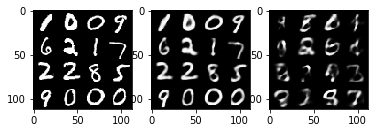

<Epoch:29/1000, Step:240/545>total_loss: 108.0378, kl_loss: 23.2807, recon_loss: 84.7571
<Epoch:30/1000, Step:195/545>total_loss: 108.5681, kl_loss: 23.4170, recon_loss: 85.1511
<Epoch:31/1000, Step:150/545>total_loss: 112.4297, kl_loss: 23.6719, recon_loss: 88.7578
<Epoch:32/1000, Step:105/545>total_loss: 109.0948, kl_loss: 23.1857, recon_loss: 85.9091
<Epoch:33/1000, Step:060/545>total_loss: 106.6563, kl_loss: 23.0977, recon_loss: 83.5587


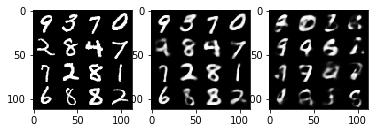

<Epoch:34/1000, Step:015/545>total_loss: 106.6544, kl_loss: 23.6885, recon_loss: 82.9659
<Epoch:34/1000, Step:515/545>total_loss: 104.5201, kl_loss: 23.0159, recon_loss: 81.5042
<Epoch:35/1000, Step:470/545>total_loss: 110.2708, kl_loss: 23.4199, recon_loss: 86.8509
<Epoch:36/1000, Step:425/545>total_loss: 111.3781, kl_loss: 23.9843, recon_loss: 87.3937
<Epoch:37/1000, Step:380/545>total_loss: 110.0839, kl_loss: 23.1362, recon_loss: 86.9477


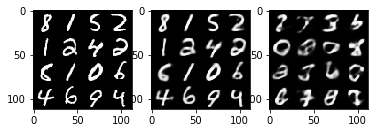

<Epoch:38/1000, Step:335/545>total_loss: 103.2473, kl_loss: 22.8273, recon_loss: 80.4200
<Epoch:39/1000, Step:290/545>total_loss: 107.1072, kl_loss: 23.5200, recon_loss: 83.5872
<Epoch:40/1000, Step:245/545>total_loss: 109.4006, kl_loss: 24.2113, recon_loss: 85.1893
<Epoch:41/1000, Step:200/545>total_loss: 108.3098, kl_loss: 23.7624, recon_loss: 84.5474
<Epoch:42/1000, Step:155/545>total_loss: 104.3091, kl_loss: 23.0062, recon_loss: 81.3029


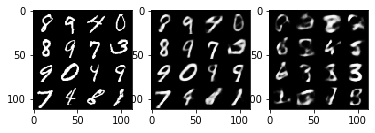

<Epoch:43/1000, Step:110/545>total_loss: 104.6500, kl_loss: 23.8837, recon_loss: 80.7663
<Epoch:44/1000, Step:065/545>total_loss: 106.3367, kl_loss: 23.5984, recon_loss: 82.7383
<Epoch:45/1000, Step:020/545>total_loss: 108.6288, kl_loss: 23.8222, recon_loss: 84.8066
<Epoch:45/1000, Step:520/545>total_loss: 103.7241, kl_loss: 23.6189, recon_loss: 80.1053
<Epoch:46/1000, Step:475/545>total_loss: 105.2198, kl_loss: 23.2954, recon_loss: 81.9243


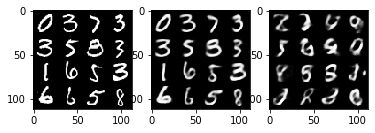

<Epoch:47/1000, Step:430/545>total_loss: 105.8559, kl_loss: 23.8831, recon_loss: 81.9727
<Epoch:48/1000, Step:385/545>total_loss: 108.5606, kl_loss: 23.7834, recon_loss: 84.7772
<Epoch:49/1000, Step:340/545>total_loss: 107.3825, kl_loss: 23.9781, recon_loss: 83.4044
<Epoch:50/1000, Step:295/545>total_loss: 105.8905, kl_loss: 23.5685, recon_loss: 82.3219
<Epoch:51/1000, Step:250/545>total_loss: 104.5602, kl_loss: 23.5374, recon_loss: 81.0229


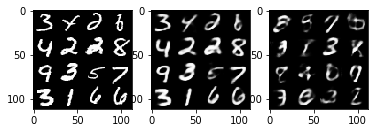

<Epoch:52/1000, Step:205/545>total_loss: 102.9773, kl_loss: 23.5569, recon_loss: 79.4203
<Epoch:53/1000, Step:160/545>total_loss: 107.0823, kl_loss: 23.7931, recon_loss: 83.2893
<Epoch:54/1000, Step:115/545>total_loss: 109.2289, kl_loss: 23.7407, recon_loss: 85.4882
<Epoch:55/1000, Step:070/545>total_loss: nan, kl_loss: nan, recon_loss: nan
<Epoch:56/1000, Step:025/545>total_loss: nan, kl_loss: nan, recon_loss: nan


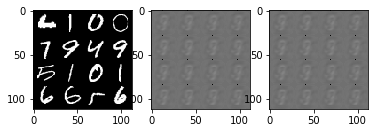

<Epoch:56/1000, Step:525/545>total_loss: nan, kl_loss: nan, recon_loss: nan
<Epoch:57/1000, Step:480/545>total_loss: nan, kl_loss: nan, recon_loss: nan
<Epoch:58/1000, Step:435/545>total_loss: nan, kl_loss: nan, recon_loss: nan
<Epoch:59/1000, Step:390/545>total_loss: nan, kl_loss: nan, recon_loss: nan
<Epoch:60/1000, Step:345/545>total_loss: nan, kl_loss: nan, recon_loss: nan


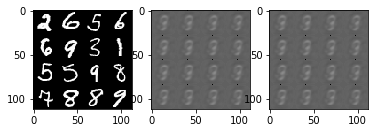

<Epoch:61/1000, Step:300/545>total_loss: nan, kl_loss: nan, recon_loss: nan
<Epoch:62/1000, Step:255/545>total_loss: nan, kl_loss: nan, recon_loss: nan
<Epoch:63/1000, Step:210/545>total_loss: nan, kl_loss: nan, recon_loss: nan
<Epoch:64/1000, Step:165/545>total_loss: nan, kl_loss: nan, recon_loss: nan


In [ ]:
x = tf.placeholder(tf.float32, [None, output_size, output_size, img_channel])

# encoding
mean, logvar = encoder(x, img_dim=output_size*output_size*img_channel, latent_dim=latent_channel)

#reparametrizing
eps = tf.placeholder(tf.float32, [None, latent_channel])
############## ToDo ##############
z = mean + tf.exp(logvar / 2) * eps
##################################

#decoding
x_hat = decoder(z, latent_dim=latent_channel, img_dim=output_size*output_size*img_channel)
x_hat = tf.reshape(x_hat, [batch_size, output_size, output_size, img_channel])

#geneartion
x_new = decoder(eps, latent_dim=latent_channel, img_dim=output_size*output_size*img_channel, reuse=True)
x_new = tf.reshape(x_new, [batch_size, output_size, output_size, img_channel])

############## ToDo ##############
#D_KL(Q(z|X) || P(z|X))
kl_loss = 0.5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mean) - 1.0 - logvar, axis=1)
kl_loss = tf.reduce_mean(kl_loss)
#E[log P(X|z)]
#convert back x_hat to logits
_epsilon = tf.convert_to_tensor(1e-8, dtype=tf.float32)
logits = tf.clip_by_value(x_hat, _epsilon, 1 - _epsilon)
logits = tf.log(logits / (1 - logits))
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=x), axis=[1,2,3])
recon_loss = tf.reduce_mean(recon_loss)
total_loss = kl_loss + recon_loss
##################################

optim = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(total_loss)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(config=config) as sess:
    sess.run(init)
    step = 0
    
    for e in range(EPOCH):
        for b in range(len(data_array)//batch_size - 1):
            step += 1
            
            img, _ = getNext_batch(data_array, data_y, b, batch_size)
            batch_eps = np.random.randn(batch_size, latent_channel)
            
            feed_dict = {x: img, eps: batch_eps}
            _ = sess.run(optim, feed_dict=feed_dict)
            
            if step % loss_step == 0:
                total, kl, recon = sess.run([total_loss, kl_loss, recon_loss], feed_dict=feed_dict)
                print('<Epoch:%d/%d, Step:%03d/%d>total_loss: %.4f, kl_loss: %.4f, recon_loss: %.4f'
                      %(e+1, EPOCH, b+1, len(data_array)//batch_size-1, total, kl, recon))
                
            if np.mod(step, display_step) == 1:
                recon_imgs, gen_imgs = sess.run([x_hat, x_new], feed_dict=feed_dict)
                recon_imgs = recon_imgs[:16, :, :, :]
                gen_imgs = gen_imgs[:16, :, :, :]
                plt.subplot(1, 3, 1)
                imgplot1 = show_images(img[:16, :, :, :], [4, 4])
                plt.subplot(1, 3, 2)
                imgplot2= show_images(recon_imgs, [4, 4])
                plt.subplot(1, 3, 3)
                imgplot3 = show_images(gen_imgs, [4, 4])
                plt.show()
        
        idx_list = np.arange(len(data_array))
        np.random.shuffle(idx_list)
        data_array = data_array[idx_list]
        data_y = data_y[idx_list]